In [4]:
from model import CustomModel

Sample data:    happiness_score  gdp_per_capita  social_support  healthy_life_expectancy  \
0            7.804           1.888           1.585                    0.535   
1            7.586           1.949           1.548                    0.537   

   freedom_to_make_life_choices  generosity  perceptions_of_corruption  \
0                         0.772       0.126                      0.535   
1                         0.734       0.208                      0.525   

  Continent_x  Marriage  Divorce  ...  INDICATOR  SUBJECT   MEASURE  \
0      Europe       4.3      2.4  ...    ALCOHOL      TOT  LT_CAP15   
1      Europe       5.6      2.6  ...    ALCOHOL      TOT  LT_CAP15   

   FREQUENCY    TIME  LITRES/CAPITA  avg_temp_c   latitude  longitude altitude  
0          A  2019.0            8.2    5.269352  62.384602  25.181444      0.0  
1          A  2019.0            9.5    9.975957  56.063592  10.339135      0.0  

[2 rows x 44 columns]
predict :  [7.6601014 7.6249995]


In [20]:
import pandas as pd
import numpy as np
from functools import cache

In [5]:
model = CustomModel()

In [7]:
transformed_X = model.preprocess(pd.read_csv(model.data_path))

In [13]:
transformed_X.describe()

,Divorce,avg_income,Expected Years of Schooling,HDI Rank (2021),Marriage,IQ,avg_temp,education_expenditure,Hemisphere_Northern Hemisphere,Hemisphere_Southern Hemisphere
count,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000
mean,1.767654,15925.545404,14.457406,75.494049,5.225290,87.570534,23.902238,875.718724,0.723343,0.247839
std,0.547052,19230.192347,2.976556,52.942059,1.552167,10.356064,7.275092,1148.712699,0.447453,0.431861
min,0.102608,-2160.935608,6.605442,-6.709134,1.642299,50.620084,6.534107,-151.471869,0.000000,0.000000
25%,1.645888,3457.245548,12.987991,26.234979,4.691702,82.090920,18.533978,175.376203,0.000000,0.000000
50%,1.800271,7446.567418,14.864440,75.580442,4.940544,88.297129,24.939487,409.746280,1.000000,0.000000
75%,1.945620,25534.570712,16.252991,113.432444,5.371833,96.122888,30.524736,1276.832423,1.000000,0.000000
max,3.970676,77959.836551,21.393843,192.438786,13.644682,107.858329,37.299458,5515.136942,1.000000,1.000000


In [11]:
transformed_X.columns

Index(['Divorce', 'avg_income', 'Expected Years of Schooling',
       'HDI Rank (2021)', 'Marriage', 'IQ', 'avg_temp',
       'education_expenditure', 'Hemisphere_Northern Hemisphere',
       'Hemisphere_Southern Hemisphere'],
      dtype='object')

In [109]:
from typing import Literal, Tuple, Optional, List

NUM_COLS = len(transformed_X.columns)

In [467]:
BINARY_COLS = transformed_X.columns.get_indexer(['Hemisphere_Northern Hemisphere', 'Hemisphere_Southern Hemisphere'])
FEATURE_TO_VALID_RANGE = {
    "Divorce": (0, 100),
    "avg_income": (-10_000, 100_000),
    "Expected Years of Schooling": (0, 50),
    "HDI Rank (2021)": (1, 191),
    "Marriage": (0, 100),
    "IQ": (0, 200),
    "avg_temp": (0, 45),
    "education_expenditure": (-10_000, 20_000),
    "Hemisphere_Northern Hemisphere": (0, 1),
    "Hemisphere_Southern Hemisphere": (0, 1)
}
FEATURE_ID_TO_VALID_RANGE = {
    transformed_X.columns.get_loc(feature): valid_range
    for feature, valid_range in FEATURE_TO_VALID_RANGE.items()
}

In [468]:
# HYPERPARAMETERS

INIT_STEP_SIZES = np.array(
    [(lo + hi) / 10 for lo, hi in FEATURE_TO_VALID_RANGE.values()]
)
POP_SIZE = 500
NUM_GENERATIONS = 100
OFFSPRING_SIZE = 50

In [469]:
def is_valid_individual(ind: np.ndarray, verbose=False) -> bool:
    for i, val in enumerate(ind):
        if val < FEATURE_ID_TO_VALID_RANGE[i][0] or val > FEATURE_ID_TO_VALID_RANGE[i][1]:
            if verbose:
                print(f"Feature {transformed_X.columns[i]} out of range: {val}")
            return False
    return True


In [470]:
CONT_MASK = np.array([True] * NUM_COLS)
CONT_MASK[BINARY_COLS] = False


class Individual:
    def __init__(self, genes: np.ndarray):
        self.genes = genes

    def make_child(self, step_sizes: np.ndarray) -> "Individual":
        # apply ES mutation to CONT_MASK genes and bit flip to BINARY_COLS genes
        child_genes = np.copy(self.genes)
        for i, gene in enumerate(self.genes):
            if CONT_MASK[i]:
                child_genes[i] = gene + np.random.normal(
                    0, step_sizes[i]
                )
                while (
                    child_genes[i] < FEATURE_ID_TO_VALID_RANGE[i][0]
                    or child_genes[i]
                    > FEATURE_ID_TO_VALID_RANGE[i][1]
                ):
                    child_genes[i] = gene + np.random.normal(
                        0, step_sizes[i]
                    )
            else:
                child_genes[i] = (
                    1.0 if np.random.rand() < 0.5 else 0.0
                )

        # hemisphere adjustment
        child_genes[-1] = 1 - child_genes[-2]

        return Individual(child_genes)

    def __repr__(self):
        feature_to_val = {
            transformed_X.columns[i]: float(self.genes[i])
            for i in range(NUM_COLS)
        }
        return f"Individual({feature_to_val})"

    @cache
    def evaluate(self) -> float:
        [happiness_idx] = model.predict(
            [self.genes], preprocess_required=False
        )
        return max(0.0, min(10.0, float(happiness_idx)))

In [471]:
CONT_MASK

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False])

In [472]:
test_ind = Individual(np.array([1.0] * NUM_COLS))

In [473]:
is_valid_individual(test_ind.genes, verbose=True)

True

In [474]:
INIT_STEP_SIZES

array([1.00e+01, 9.00e+03, 5.00e+00, 1.92e+01, 1.00e+01, 2.00e+01,
       4.50e+00, 1.00e+03, 1.00e-01, 1.00e-01])

In [475]:
test_ind.make_child(INIT_STEP_SIZES)

Individual({'Divorce': 0.1052549885467432, 'avg_income': -6805.670905927201, 'Expected Years of Schooling': 10.76405107083134, 'HDI Rank (2021)': 34.67741683249703, 'Marriage': 4.917577583383961, 'IQ': 16.803305609504466, 'avg_temp': 0.23156275488781997, 'education_expenditure': 1145.8091570120455, 'Hemisphere_Northern Hemisphere': 0.0, 'Hemisphere_Southern Hemisphere': 1.0})

In [476]:
def initial_population(random_ratio: float = 0.2) -> List[Individual]:
    train_pop_size = int(POP_SIZE * (1 - random_ratio))
    random_pop_size = POP_SIZE - train_pop_size
    train_pop = transformed_X.sample(n=train_pop_size, replace=False).to_numpy()
    random_pop = np.random.uniform(
        low=[lo for lo, _ in FEATURE_TO_VALID_RANGE.values()],
        high=[hi for _, hi in FEATURE_TO_VALID_RANGE.values()],
        size=(random_pop_size, NUM_COLS)
    )
    return [Individual(ind) for ind in np.concatenate([train_pop, random_pop])]

In [477]:
def update_stepsizes(success_rate: float, step_sizes: np.ndarray) -> None:
    if success_rate > 1 / 5:
        return step_sizes * np.exp(1 / np.sqrt(2 * NUM_COLS))
    else:
        return step_sizes * np.exp(-1 / np.sqrt(2 * NUM_COLS))

In [478]:
import random
record_keeper = {
    "min": lambda pop: pop[-1].evaluate(),
    "max": lambda pop: pop[0].evaluate(),
    "mean": lambda pop: float(
        np.mean([ind.evaluate() for ind in pop])
    ),
}

pop = initial_population()
records = [{key: record_keeper[key](pop) for key in record_keeper}]


def tournament_selection(pop, tournament_size=5) -> Individual:
    """Randomly select individuals and return the best of a random sample"""
    tournament = np.random.choice(pop, tournament_size)
    return max(tournament, key=lambda ind: ind.evaluate())

def evaluate_individual(individual):
    return individual.evaluate()


print(records[0])
step_sizes = INIT_STEP_SIZES
NUM_ELITES = 5

fitnesses = [ind.evaluate() for ind in pop]
SADDEST = pop[np.argmin(fitnesses)]

for _ in range(NUM_GENERATIONS):
    # print("starting mutation")

    success_count = 0
    for i in range(OFFSPRING_SIZE):
        # parent = pop[np.random.randint(0, POP_SIZE)]
        parent = tournament_selection(pop)
        child = parent.make_child(step_sizes)
        success_count += int(
            evaluate_individual(child) > evaluate_individual(parent)
        )
        pop.append(child)

    # print("end mutation")
    step_sizes = update_stepsizes(
        success_rate=success_count / OFFSPRING_SIZE,
        step_sizes=step_sizes,
    )
    pop.sort(key=lambda ind: ind.evaluate(), reverse=True)
    pop = pop[:NUM_ELITES] + random.sample(pop[10:], POP_SIZE - NUM_ELITES)
    assert len(pop) == POP_SIZE
    # print("end selection")

    fitnesses = [ind.evaluate() for ind in pop]
    min_fitness_id = np.argmin(fitnesses)
    if fitnesses[min_fitness_id] < SADDEST.evaluate():
        SADDEST = pop[min_fitness_id]
    record = {"min": min(fitnesses), "max": max(fitnesses), "mean": float(np.mean(fitnesses))}
    assert record["max"] >= record["mean"] >= record["min"]
    print(list(record.values()))
    records.append(record)

{'min': 6.025277137756348, 'max': 7.219786167144775, 'mean': 5.80679444360733}
[1.9642589092254639, 8.07011890411377, 5.890814490795136]
[1.9642589092254639, 8.07011890411377, 5.9832265138626095]
[1.9642589092254639, 8.07011890411377, 6.110342915534973]
[1.9642589092254639, 8.094164848327637, 6.1946494908332825]
[1.9642589092254639, 8.094164848327637, 6.264376212120056]
[1.9642589092254639, 8.094164848327637, 6.2959106864929195]
[1.9642589092254639, 8.131979942321777, 6.356345960617065]
[1.9642589092254639, 8.131979942321777, 6.424272018432617]
[1.9642589092254639, 8.131979942321777, 6.442211037635803]
[1.9642589092254639, 8.131979942321777, 6.4310051612854]
[1.9642589092254639, 8.131979942321777, 6.456623218536377]
[1.9642589092254639, 8.131979942321777, 6.5125548963546755]
[1.9642589092254639, 8.131979942321777, 6.589887907028198]
[1.9642589092254639, 8.131979942321777, 6.609561594963074]
[1.9642589092254639, 8.131979942321777, 6.682902029514313]
[1.9642589092254639, 8.13197994232177

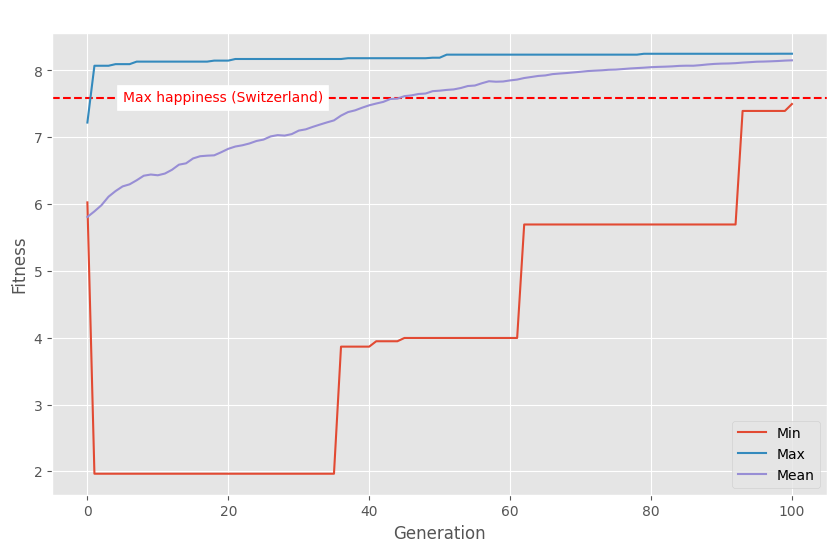

In [510]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
# Extract min, max, and mean values from records
min_values = [record["min"] for record in records]
max_values = [record["max"] for record in records]
mean_values = [record["mean"] for record in records]

SWISS_MAX_HAPPINESS_THRESHOLD = 7.59

# Plot the values
plt.figure(figsize=(10, 6))
plt.axhline(
    y=SWISS_MAX_HAPPINESS_THRESHOLD, color="r", linestyle="--"
)
plt.text(
    5,
    SWISS_MAX_HAPPINESS_THRESHOLD,
    "Max happiness (Switzerland)",
    color="r",
    va="center",
    ha="left",
    backgroundcolor="white",
)
plt.plot(min_values, label="Min")
plt.plot(max_values, label="Max")
plt.plot(mean_values, label="Mean")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations")
plt.legend()
legend = plt.legend()
for text in legend.get_texts():
    text.set_color("black")
plt.show()

In [490]:
fitnesses = [ind.evaluate() for ind in pop]
indices_by_fitness = np.argsort(fitnesses)
[pop[i] for i in indices_by_fitness[-40:]]

[Individual({'Divorce': 99.7047944483689, 'avg_income': 34209.59679129646, 'Expected Years of Schooling': 35.36871032971018, 'HDI Rank (2021)': 4.249391174571807, 'Marriage': 95.92754958863856, 'IQ': 101.63852345318222, 'avg_temp': 5.314073735282143, 'education_expenditure': 10189.522692683166, 'Hemisphere_Northern Hemisphere': 1.0, 'Hemisphere_Southern Hemisphere': 0.0}),
 Individual({'Divorce': 93.87162681559553, 'avg_income': 36627.48401383356, 'Expected Years of Schooling': 32.99220735228067, 'HDI Rank (2021)': 5.196601382842981, 'Marriage': 99.99608813650325, 'IQ': 101.28741395005227, 'avg_temp': 0.5838186885619163, 'education_expenditure': 9610.118749185991, 'Hemisphere_Northern Hemisphere': 0.0, 'Hemisphere_Southern Hemisphere': 1.0}),
 Individual({'Divorce': 94.31833636460912, 'avg_income': 40102.47827656482, 'Expected Years of Schooling': 30.53108928696211, 'HDI Rank (2021)': 7.3273696898296645, 'Marriage': 93.54721385426792, 'IQ': 101.53801177755574, 'avg_temp': 2.08342052711

In [491]:
HAPPINESS_THRESHOLD = 7.59
happiest = [ind for ind in pop if ind.evaluate() > HAPPINESS_THRESHOLD]

497

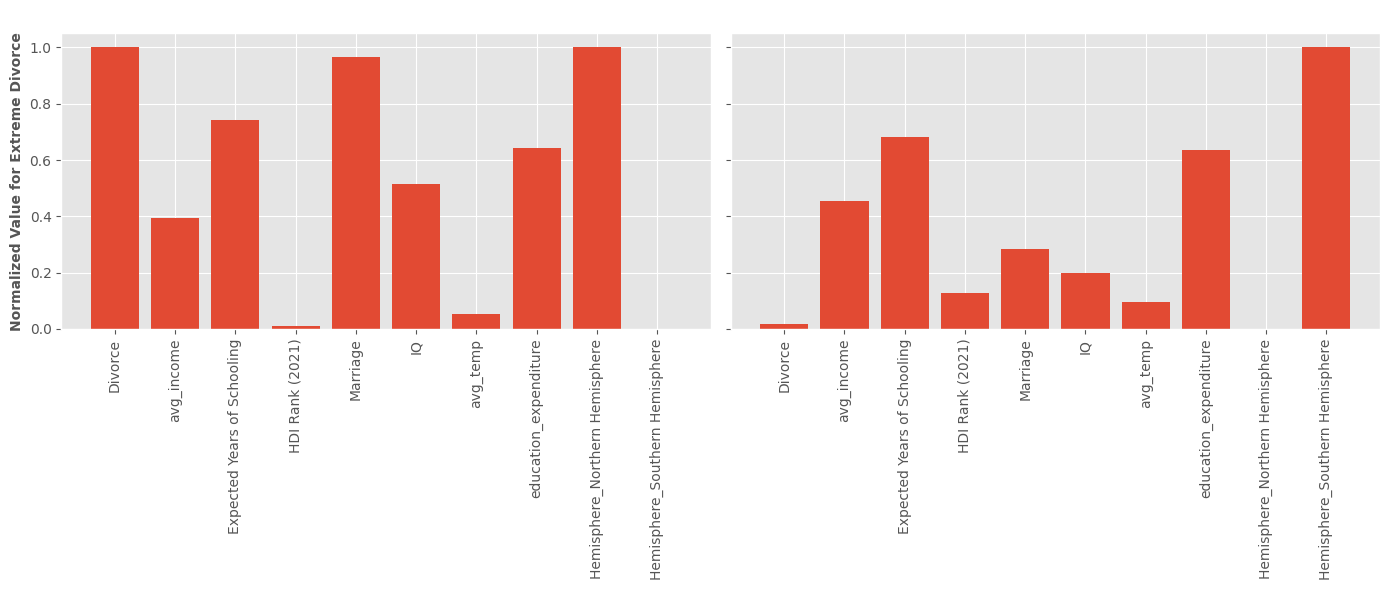

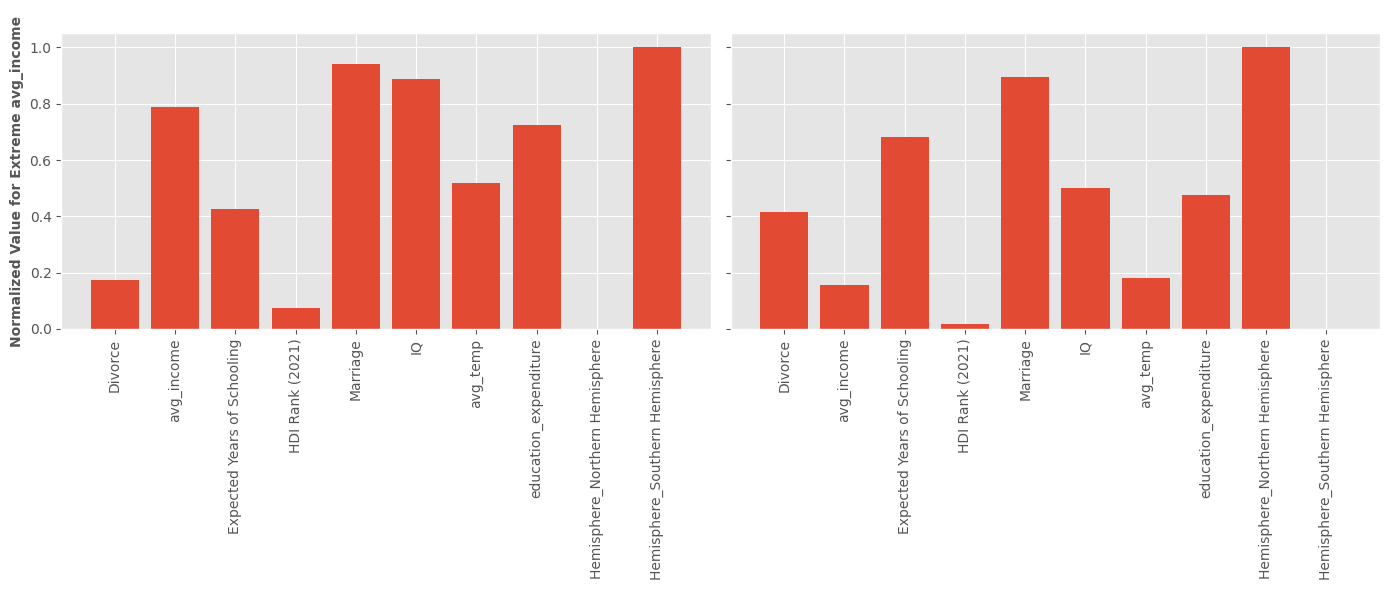

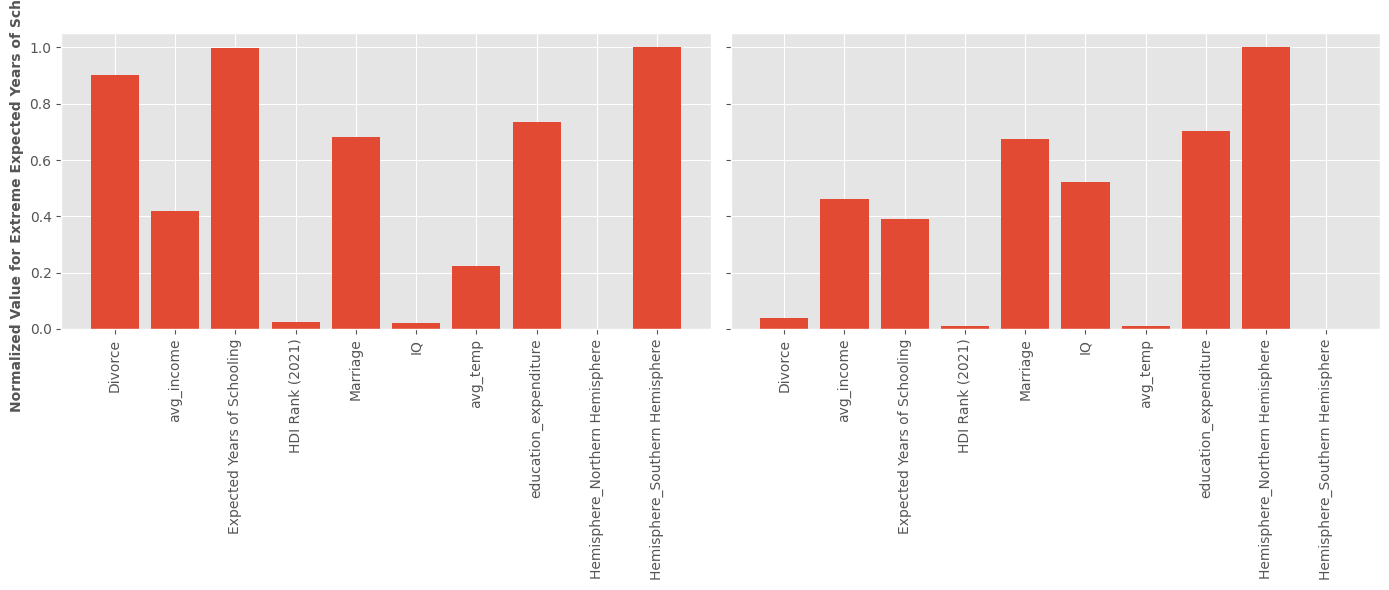

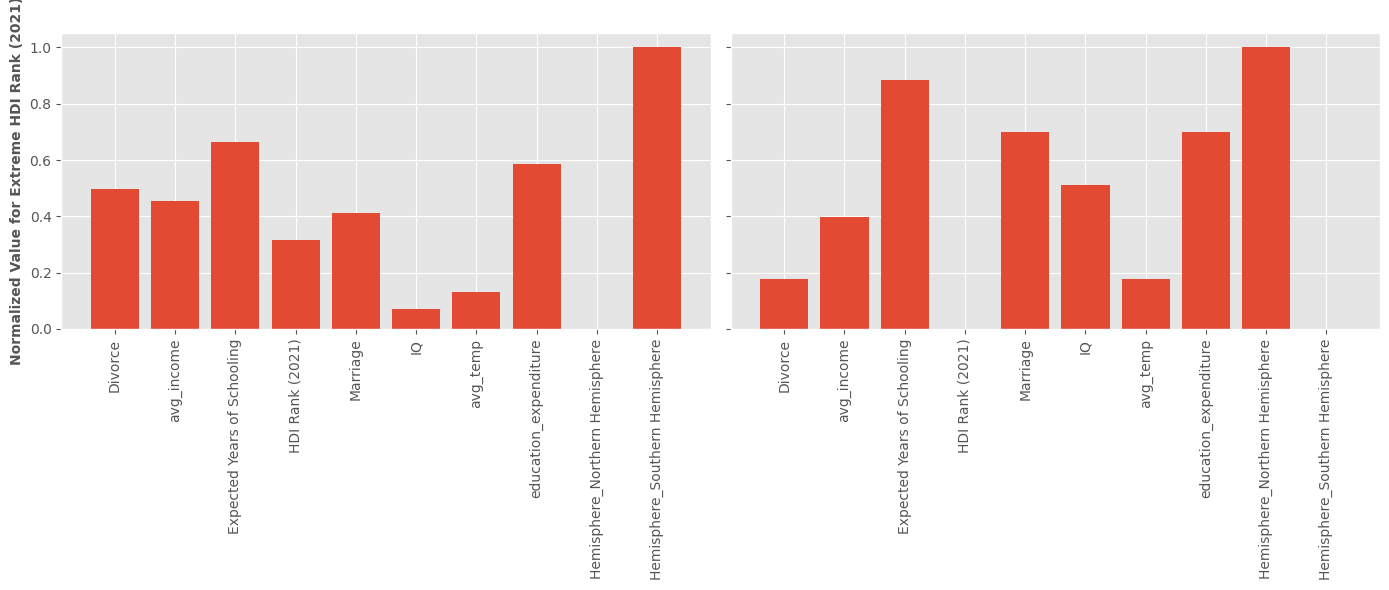

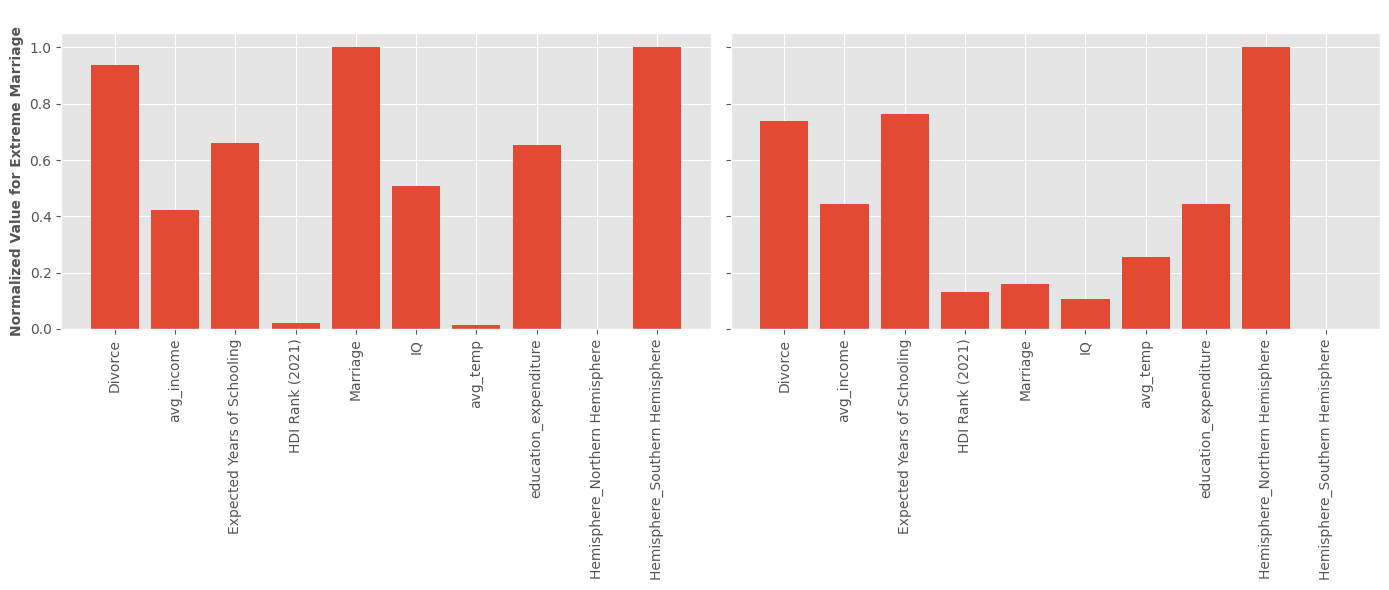

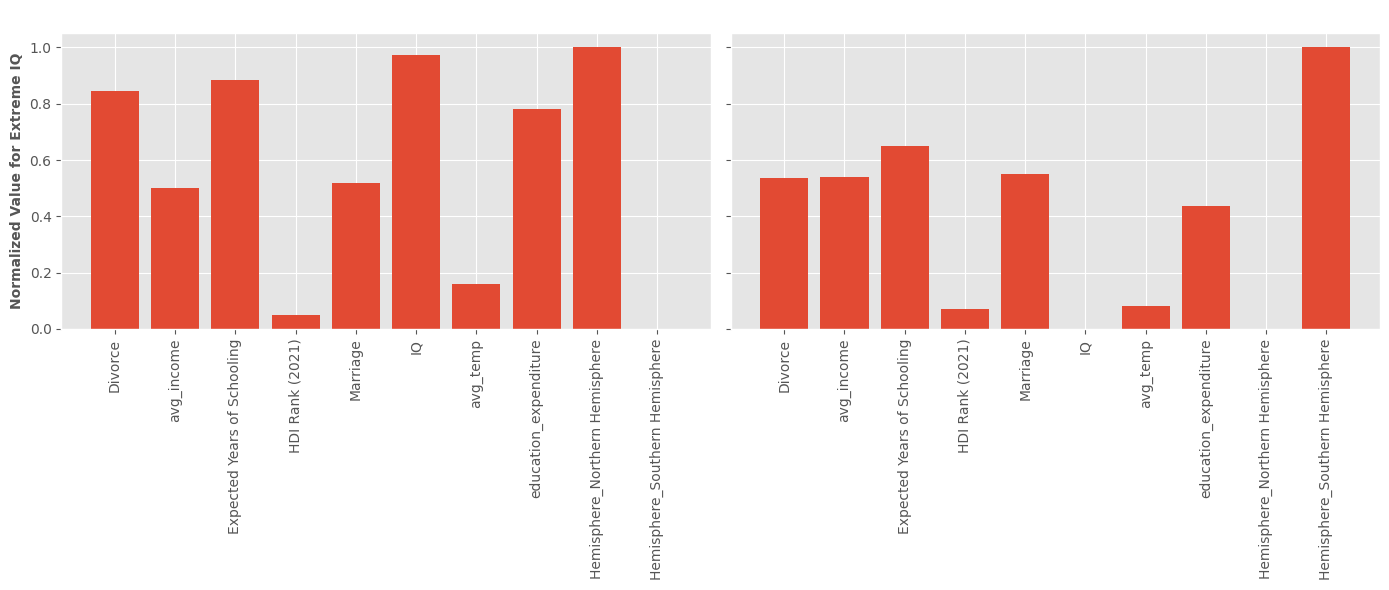

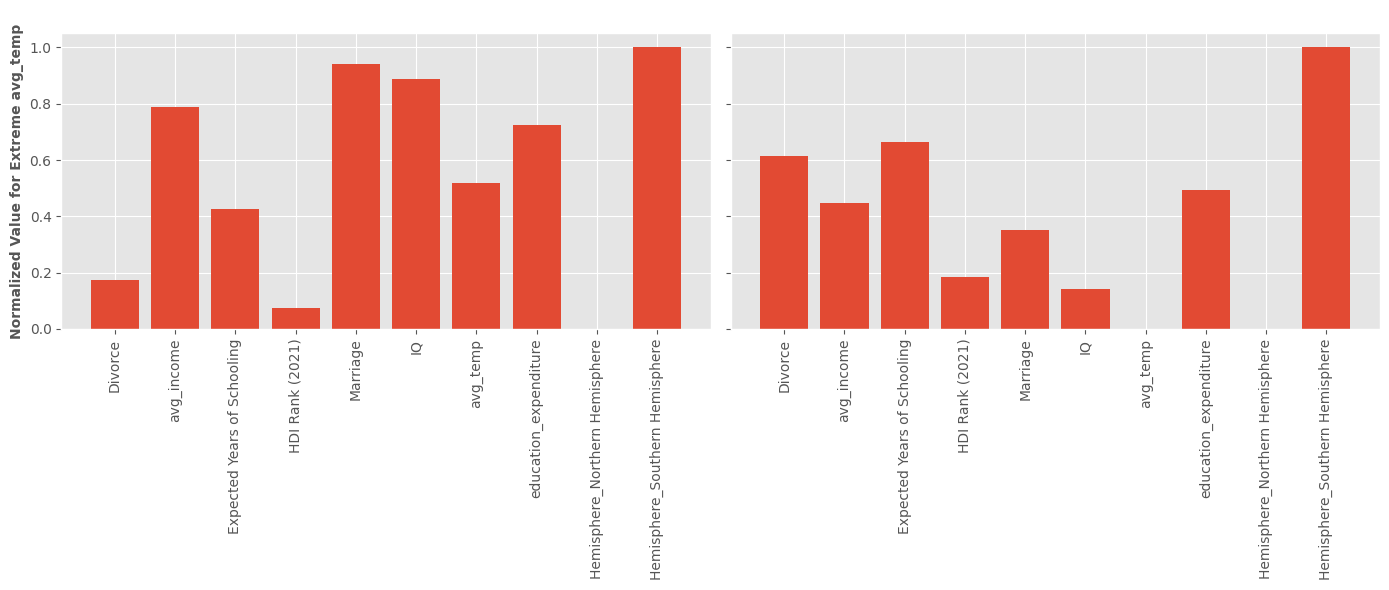

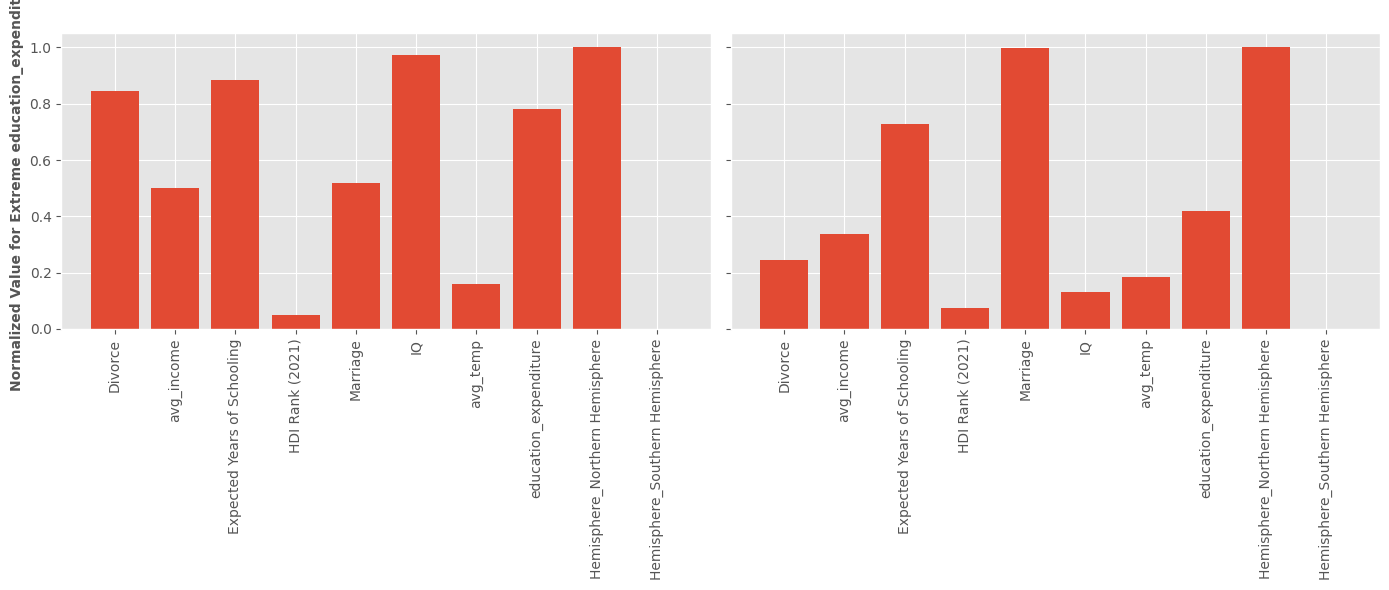

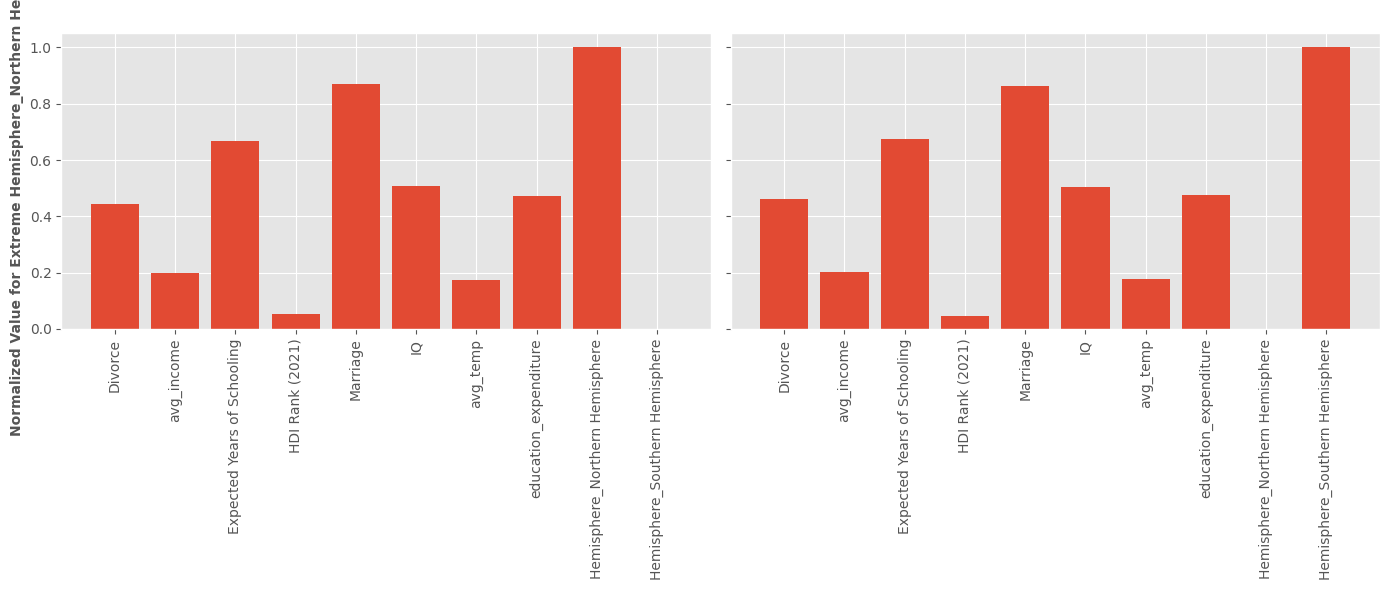

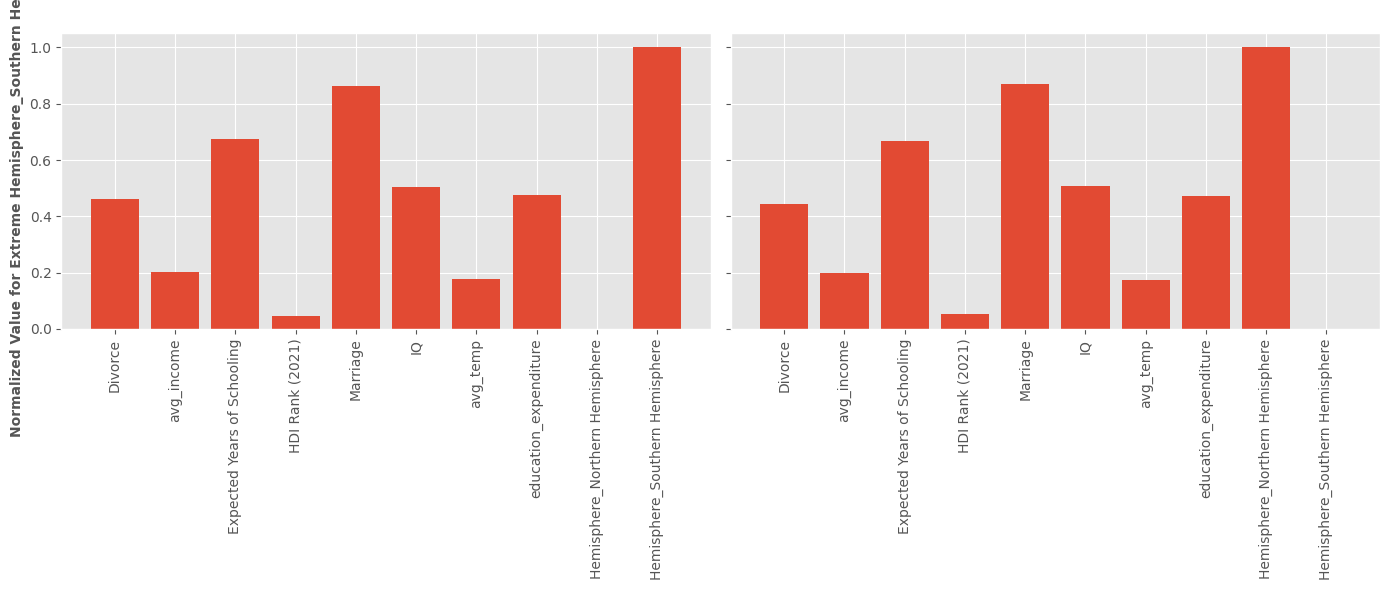

In [ ]:
# * find the happiest invidual with max and min feature values for each feature
for feature in transformed_X.columns:
    max_feature_happiest = max(
        happiest,
        key=lambda ind: ind.genes[
            transformed_X.columns.get_loc(feature)
        ],
    )
    min_feature_happiest = min(
        happiest,
        key=lambda ind: ind.genes[
            transformed_X.columns.get_loc(feature)
        ],
    )

    # Normalize the feature values for plotting
    max_feature_happiest_normalized = [
        (
            max_feature_happiest.genes[
                transformed_X.columns.get_loc(feature)
            ]
            - FEATURE_TO_VALID_RANGE[feature][0]
        )
        / (
            FEATURE_TO_VALID_RANGE[feature][1]
            - FEATURE_TO_VALID_RANGE[feature][0]
        )
        for feature in transformed_X.columns
    ]

    min_feature_happiest_normalized = [
        (
            min_feature_happiest.genes[
                transformed_X.columns.get_loc(feature)
            ]
            - FEATURE_TO_VALID_RANGE[feature][0]
        )
        / (
            FEATURE_TO_VALID_RANGE[feature][1]
            - FEATURE_TO_VALID_RANGE[feature][0]
        )
        for feature in transformed_X.columns
    ]

    # Plot the normalized values
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    axes[0].bar(
        transformed_X.columns, max_feature_happiest_normalized
    )
    axes[0].set_title(f"Normalized Values for Extreme {feature}")
    axes[0].set_ylabel(f"Normalized Value for Extreme {feature}", fontsize=10, fontweight="bold")
    axes[0].tick_params(axis="x", rotation=90)

    axes[1].bar(
        transformed_X.columns, min_feature_happiest_normalized
    )
    axes[1].tick_params(axis="x", rotation=90)

    plt.tight_layout()
    plt.show()



In [487]:
SADDEST

Individual({'Divorce': 1.800270883444213, 'avg_income': 972.5668958784776, 'Expected Years of Schooling': 10.249823191387373, 'HDI Rank (2021)': 182.01273839226263, 'Marriage': 4.940543733983164, 'IQ': 80.82311289706125, 'avg_temp': 23.85217509580411, 'education_expenditure': -9.24656157342066, 'Hemisphere_Northern Hemisphere': 1.0, 'Hemisphere_Southern Hemisphere': 0.0})

In [489]:
[fitnesses[i] for i in indices_by_fitness[-40:]]

[8.224141120910645,
 8.224141120910645,
 8.224141120910645,
 8.224141120910645,
 8.224141120910645,
 8.224141120910645,
 8.224141120910645,
 8.226487159729004,
 8.227408409118652,
 8.228856086730957,
 8.228856086730957,
 8.228856086730957,
 8.228856086730957,
 8.231775283813477,
 8.231775283813477,
 8.231775283813477,
 8.236281394958496,
 8.236391067504883,
 8.236391067504883,
 8.236391067504883,
 8.236391067504883,
 8.236391067504883,
 8.236391067504883,
 8.238627433776855,
 8.241106033325195,
 8.242522239685059,
 8.242522239685059,
 8.242522239685059,
 8.242522239685059,
 8.242522239685059,
 8.242522239685059,
 8.242522239685059,
 8.242522239685059,
 8.247235298156738,
 8.249486923217773,
 8.250154495239258,
 8.250154495239258,
 8.250154495239258,
 8.250154495239258,
 8.250154495239258]

In [483]:
pop[:10]

[Individual({'Divorce': 46.19562407699389, 'avg_income': 12114.054852931631, 'Expected Years of Schooling': 33.66557355493004, 'HDI Rank (2021)': 9.846304343312807, 'Marriage': 86.44589021862689, 'IQ': 101.08180191649535, 'avg_temp': 7.969145037173075, 'education_expenditure': 4249.623573419323, 'Hemisphere_Northern Hemisphere': 0.0, 'Hemisphere_Southern Hemisphere': 1.0}),
 Individual({'Divorce': 45.78341258713307, 'avg_income': 12128.067277114562, 'Expected Years of Schooling': 33.531622217880106, 'HDI Rank (2021)': 10.843733156443827, 'Marriage': 86.10928872073852, 'IQ': 101.3680231186874, 'avg_temp': 7.60789491979036, 'education_expenditure': 4264.095951542824, 'Hemisphere_Northern Hemisphere': 0.0, 'Hemisphere_Southern Hemisphere': 1.0}),
 Individual({'Divorce': 44.538712254857934, 'avg_income': 11880.807716654828, 'Expected Years of Schooling': 33.39303319426105, 'HDI Rank (2021)': 11.377378448542036, 'Marriage': 86.83568064188017, 'IQ': 101.76077603301509, 'avg_temp': 7.83677182

In [484]:
INIT_STEP_SIZES

array([1.00e+01, 9.00e+03, 5.00e+00, 1.92e+01, 1.00e+01, 2.00e+01,
       4.50e+00, 1.00e+03, 1.00e-01, 1.00e-01])

In [485]:
step_sizes

array([4.36961549e-01, 3.93265394e+02, 2.18480775e-01, 8.38966175e-01,
       4.36961549e-01, 8.73923099e-01, 1.96632697e-01, 4.36961549e+01,
       4.36961549e-03, 4.36961549e-03])

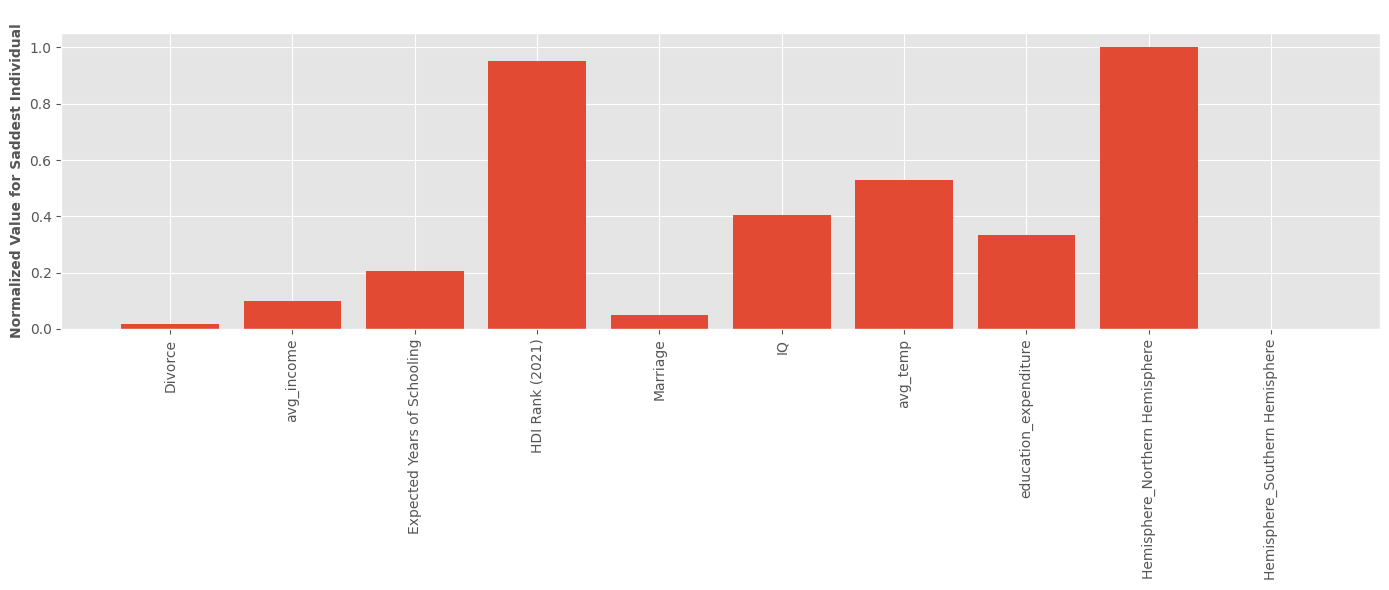

In [531]:
# Plot the normalized values for the saddest individual
saddest_normalized = [
    (SADDEST.genes[transformed_X.columns.get_loc(feature)] - FEATURE_TO_VALID_RANGE[feature][0])
    / (FEATURE_TO_VALID_RANGE[feature][1] - FEATURE_TO_VALID_RANGE[feature][0])
    for feature in transformed_X.columns
]

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(transformed_X.columns, saddest_normalized)
ax.set_title("Normalized Values for Saddest Individual")
ax.set_ylabel("Normalized Value for Saddest Individual", fontsize=10, fontweight="bold")
ax.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()